In [1]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2
using Plots
pyplot()  

cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:1369


## turned on boiling

# the plate code initialization

### Physical parameters

In [2]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Geometry parameters

In [17]:
inch = 2.54e-2;
Lx = 0.1524;
Ly = 0.0648;

In [18]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [19]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Te = RigidTransform((0.7inch,-0.0),0.0)
Te(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Te = RigidTransform((-0.7inch,-0.0),0.0)
Te(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tc = RigidTransform((-2.5inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tc = RigidTransform((2.5inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0*10 #~~~~~~~~~~~~~~
# qe = 15500.0
hc = 1500.0
Tc = 0.0

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

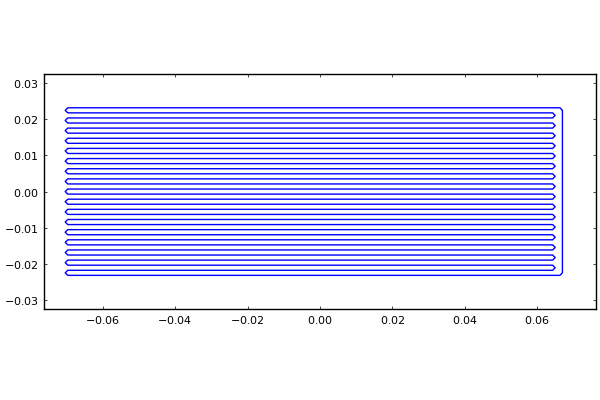

In [20]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = 46.25*1e-3
height = 133.83*1e-3
gap = d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)


In [21]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [22]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


### Initialize state, and create the integrator

In [23]:
u0 = newstate(sys)
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator);

### Set up values for the OHP heat flux per unit length and advance the solution

In [24]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


### Time marching

In [25]:
num = 1000
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

  9.934282 seconds (264.06 k allocations: 13.124 GiB, 9.21% gc time)


In [26]:
typeof(sys.qline[1].arccoord)

ScalarData{5601,Float64,Array{Float64,1}}

### Plotting temperature contours

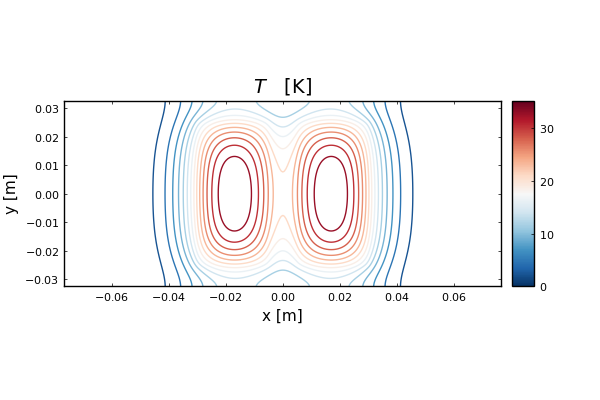

In [27]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

### Plot the temperature along the OHP channel

In [28]:
# plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [29]:
nondi_Q_to_Q = 1.35E+02
t_to_nondi_t = 2.83E-01
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [30]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
#     Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hₗ   =  1.01E+03; # liquid wall heat transfer coeffcient for static fluids
    Hδ  = 4.65E+02;


In [31]:
    d = 6.56e-3 # dimensionless diameter
    L = 34.35  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [32]:
    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     boilingΔt = 0.05

In [33]:
tube = Tube(d,L,L2D,angle,closedornot);

In [34]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [35]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [36]:
X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)


realratio

0.43607342924528625

In [37]:
N=numpts(ohp)

ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [51]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
# Hδ = 4.64E+02
P = 0*zeros(length(X0)) .+ 1.0;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δ = 0*zeros(length(X0)) .+ 2.27E-02 ; # use a random film thickness
vapors=Vapor(γ,Hδ,P,δ);

In [52]:
α = 1.154e-5 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
# Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [53]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [54]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [55]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [56]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [106]:
tspan = (0.0, 0.1);
dt_record = tspan[2] /100;

tstep=1e-3

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [107]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
Tplate = temperature(integrator_plate);

In [108]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep*t_to_nondi_t, callback=cbst);

In [109]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

In [110]:
# integrator_plate = plate_hist[end-3]
# integrator_tube = tube_hist[end-3]

# currentsys = integrator_tube.p
# currentsys = getcurrentsys(integrator_tube.u,currentsys);

# tspan = (integrator_plate.t, integrator_plate.t + 1.0);
# dt_record = 0.01

In [111]:
# tspan = (integrator_plate.t, integrator_plate.t + 0.2);
# dt_record = tstep

In [112]:

@time for t in tspan[1]:tstep:tspan[2]
    

  for j in 1:N_iter
        currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
        currentsys = getcurrentsys(integrator_tube.u,currentsys)


        nondi_qtmp = sys_to_heatflux(currentsys)
        qtmp = nondi_Q_to_Q*nondi_qtmp
        set_linesource_strength!(sys,qtmp)


        Tplate = ADI_timemarching!(Tplate,sys,tstep)
    end
    integrator_plate.t += tstep
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep*t_to_nondi_t);
    step!(integrator_tube);
#     @time step!(integrator_tube, tstep*t_to_nondi_t)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011000000000000003
0.012000000000000004
0.013000000000000005
0.014000000000000005
0.015000000000000006
0.016000000000000007
0.017000000000000008
0.01800000000000001
0.01900000000000001
0.02000000000000001
0.02100000000000001
0.022000000000000013
0.023000000000000013
0.024000000000000014
0.025000000000000015
0.026000000000000016
0.027000000000000017
0.028000000000000018
0.02900000000000002
0.03000000000000002
0.03100000000000002
0.03200000000000002
0.03300000000000002
0.03400000000000002
0.035000000000000024
0.036000000000000025
0.037000000000000026
0.03800000000000003
0.03900000000000003
0.04000000000000003
0.04100000000000003
0.04200000000000003
0.04300000000000003
0.04400000000000003
0.04500000000000003
0.046000000000000034
0.047000000000000035
0.048000000000000036
0.04900000000000004
0.05000000000000004
0.05100000000000004
0.05200000000000004
0.05300000000000004
0.05400000000000004
0.05500000

In [113]:
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)

0.10100000000000008


In [114]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [115]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

In [116]:
maximum(temperature(plate_hist[end])[:])

1.1682803009106846

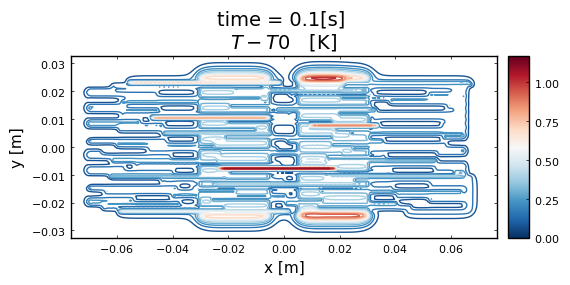

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
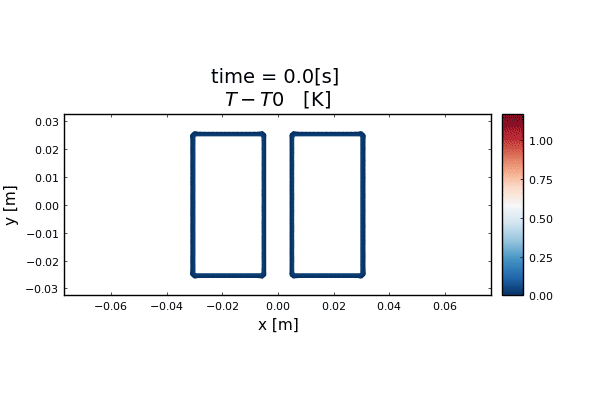

In [117]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = minimum(temperature(plate_hist[end-1])[:])
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1  
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T - T0 \quad [\mathrm{K}]"))
end

In [118]:
minimum(temperature(plate_hist[end]))

-0.00027702930551011583

In [119]:
length(plate_hist)

102

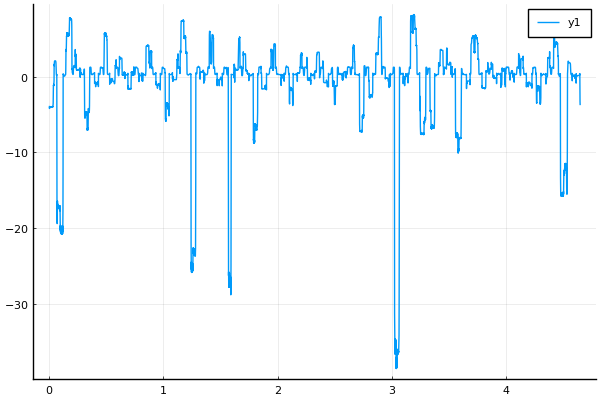

In [120]:
plot(sys.qline[1].arccoord,sys_to_heatflux(sysfinal[end]))

In [121]:
@gif for i=1:10:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

LoadError: [91mInterruptException:[39m

# plot the OHP

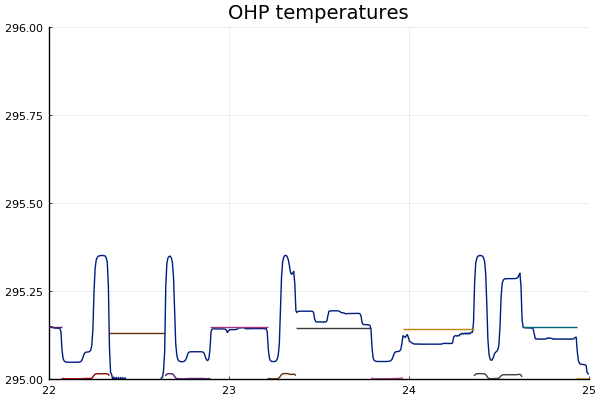

In [122]:
plot(sysfinal[61],xlim=(22.0,25.0),ylim=(295.0,296.0))

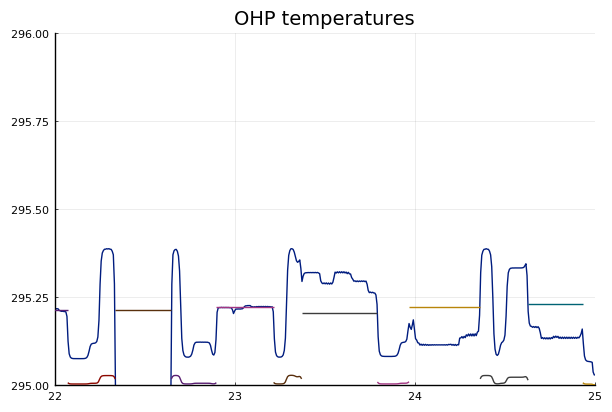

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
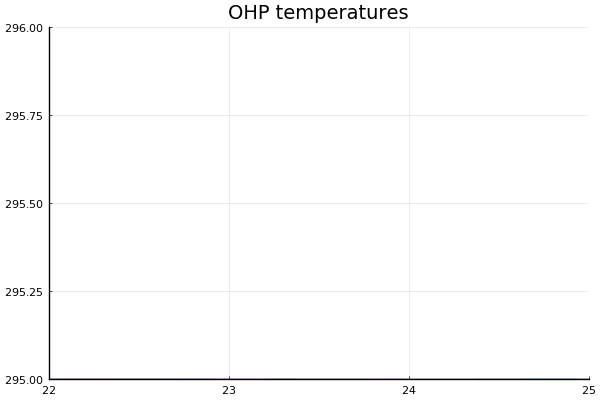

In [123]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],xlim=(22.0,25.0),ylim=(295.0,296.0))
end

In [113]:
sysfinal[end].mapping.H_interp_liquidtowall[8.5:0.01:8.7]

21-element Array{Float64,1}:
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.996635495361
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.996635495358
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.99663549536
  1010.0
  1010.0
  1010.0
  1010.0
  1010.0
  1010.0
  1010.0

In [85]:
plot(sysfinal[end-30],plottype="T",xlim=(8.0,9.0))

LoadError: [91mBoundsError: attempt to access 3-element Array{Any,1} at index [-27][39m

In [86]:
plot(sysfinal[end-3],plottype="T",xlim=(8.0,9.0))

LoadError: [91mBoundsError: attempt to access 3-element Array{Any,1} at index [0][39m

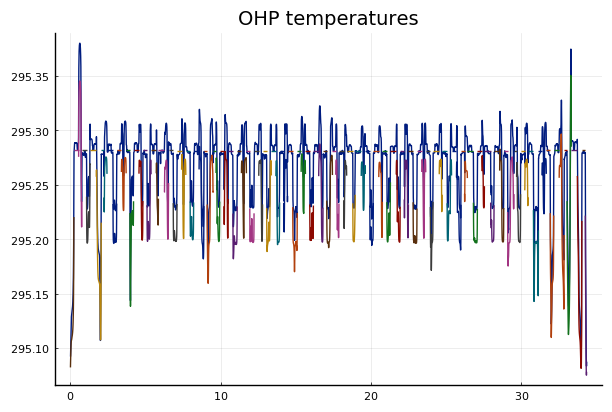

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
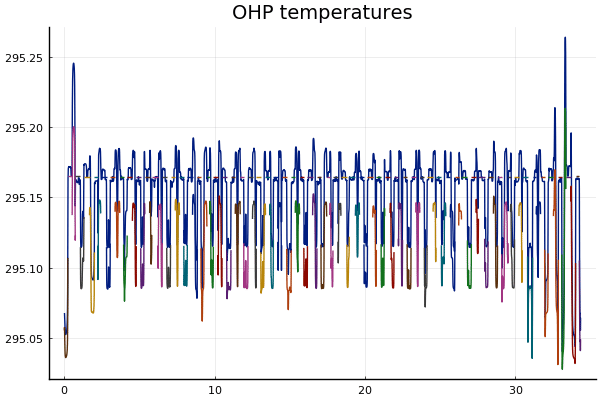

In [87]:
@gif for ii=1:length(sysfinal)
    plot(sysfinal[ii])
end

In [88]:
# plate_hist, integrator_plate = load("plate_OHP_boiling.jld2", "plate_hist",  "integrator_plate")

In [89]:
# tube_hist, integrator_tube = load("tube_OHP_boiling.jld2", "tube_hist",  "integrator_tube")

In [90]:
save("plate_OHP2.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [91]:
save("tube_OHP2.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [114]:
inch = 2.54e-2;

# x = [-2.7inch,0.0,2.7inch];
# y = [0.0,0.0,0.0];

x = [0.0]
y = [0.0]

X =  VectorData(x,y);

In [115]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [116]:
ghist = []
thist = []
for i = 1:length(plate_hist)
    H(g,temperature(plate_hist[i]))
    append!(ghist,deepcopy(g))
    append!(thist,plate_hist[i].t)
end

In [117]:
RTDx,RTDy = load("RTD4.jld2","RTDx","RTDy")

([10.89866157, 14.34034417, 21.22370937, 37.8585086, 64.24474187, 96.36711281, 125.6214149, 152.581262, 182.4091778, 211.0898662, 247.2275335, 275.334608], [16.58279415, 20.15358253, 23.16569499, 25.33894001, 26.617514, 27.22537814, 27.38734721, 27.60554664, 27.82321258, 27.81787763, 28.03436988, 27.97333806])

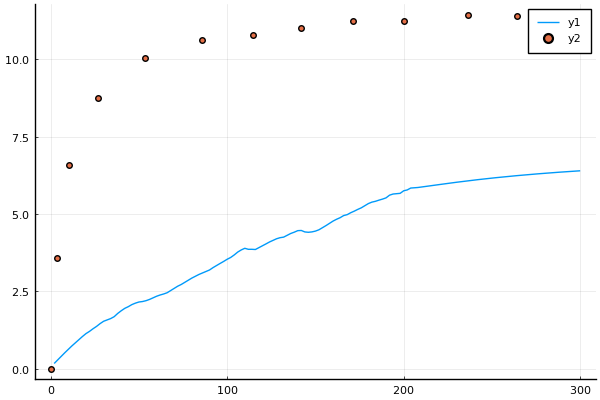

In [118]:
plot(thist,ghist)
scatter!(RTDx .- RTDx[1],RTDy .- RTDy[1])